# Test of hypothesis for the 2022-2023 customer data

In [1]:
source('../load_environment.R')
options(repr.plot.width=6, repr.plot.height=4)

Pivot Bio, Inc.
This code performs analyses supporting findings of the paper entitled:
"Genetic remodeling of soil diazotrophs enables partial replacement of synthetic nitrogen fertilizer with biological nitrogen fixation in maize".

##------ Mon Aug 19 14:35:13 2024 ------## 
Loaded packages:  tidyverse, readxl, broom, foreach, nlme, lme4, lmerTest, glmmTMB, car, DHARMa, caret, emmeans, multcomp, ggpubr, scales, png, ggthemes and their dependencies.
A complete list of packages used in the analysis is provided in the `packages_citations.txt` file.


In [2]:
## to chlorophyll concentration https://onlinelibrary.wiley.com/doi/full/10.1111/pce.12324
cci_2_cc <- function(x) -121 + 129*(x)^0.42
cc_2_cci <- function(x) ((x + 121)/(129))^(1/0.42)

### Load dataset

In [3]:
cust <- read_csv("./datasets/on_farm_veg_plant_traits_anonymized.csv")
cust$chlorophyll <- cci_2_cc(cust$cci) 
cust$treatment <- factor(cust$treatment) 

Rows: 280 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (4): field_id, field_id_hash, growth_stage, treatment
dbl (3): n_fert_reduced_kgha, fresh_weight_g, cci

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
cust$field_id_hash %>% unique() %>% length()

[1] 135

In [5]:
cust$growth_stage %>% unique()

[1] "V7"  "VT"  "V12" "V11" "V9"  "V6"  "V8"  "V10" "V15" "V13" "V14"

In [6]:
# Check if we have sites with more than one measurement

cust %>%
dplyr::select(field_id_hash,growth_stage) %>%
unique() %>% 
group_by(field_id_hash)  %>%
summarise(n = n()) %>% 
filter(n > 1)

field_id_hash,n
<chr>,<int>
04b6431a,2
09ee19a3,2
21913575,2
aa19951e,2
e56a48fd,2


### Analysis of chlorophyll concentrations

In [7]:
cust <- cust %>%
transmute(field_id_hash,growth_stage,treatment,fresh_weight_g,chlorophyll) %>% 
gather(variable,value,fresh_weight_g,chlorophyll) %>% 
spread(treatment,value) %>% 
mutate(delta = PROVEN40 - BAU) %>% 
split(.$variable)


	Shapiro-Wilk normality test

data:  cust$chlorophyll$delta
W = 0.97263, p-value = 0.006513


Warning message:
"`qplot()` was deprecated in ggplot2 3.4.0."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


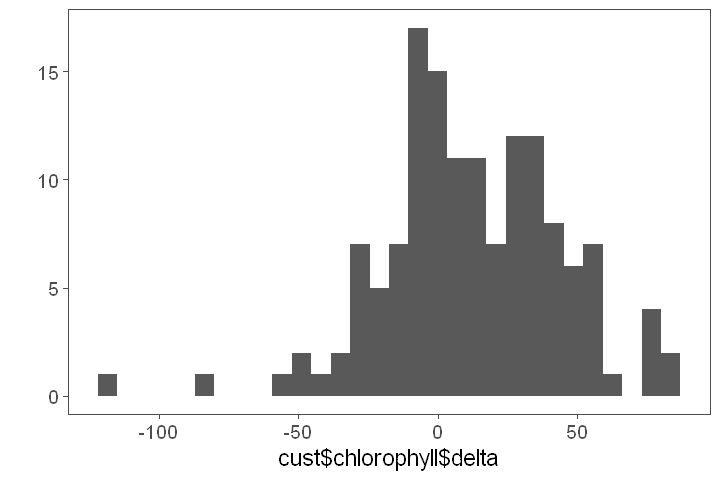

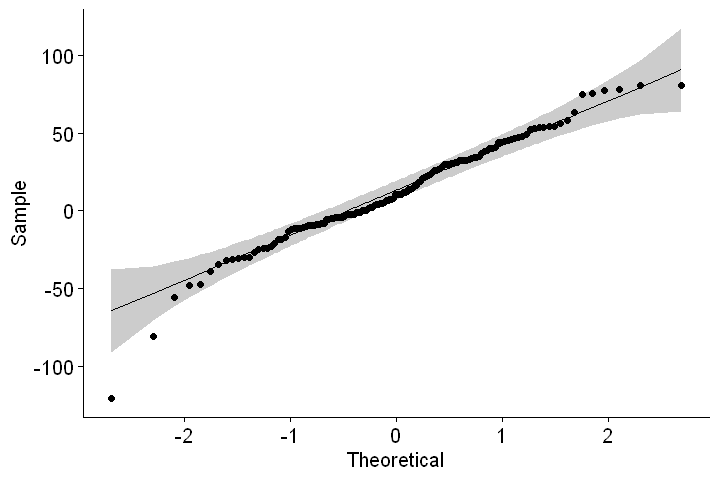

In [8]:
shapiro.test(cust$chlorophyll$delta)
#skewness(cust$chlorophyll$delta)
qplot(geom = "histogram",cust$chlorophyll$delta)
ggqqplot(cust$chlorophyll$delta)



In [9]:
ttest_chlorophyll <- wilcox.test(cust$chlorophyll$PROVEN40,cust$chlorophyll$BAU, paired = TRUE,conf.int = TRUE)
ttest_chlorophyll


	Wilcoxon signed rank test with continuity correction

data:  cust$chlorophyll$PROVEN40 and cust$chlorophyll$BAU
V = 6969, p-value = 9.753e-06
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
  7.212793 17.713370
sample estimates:
(pseudo)median 
      12.64591 


### Analysis of plant fresh weight biomass


	Shapiro-Wilk normality test

data:  cust$fresh_weight_g$delta
W = 0.90147, p-value = 3.796e-08


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


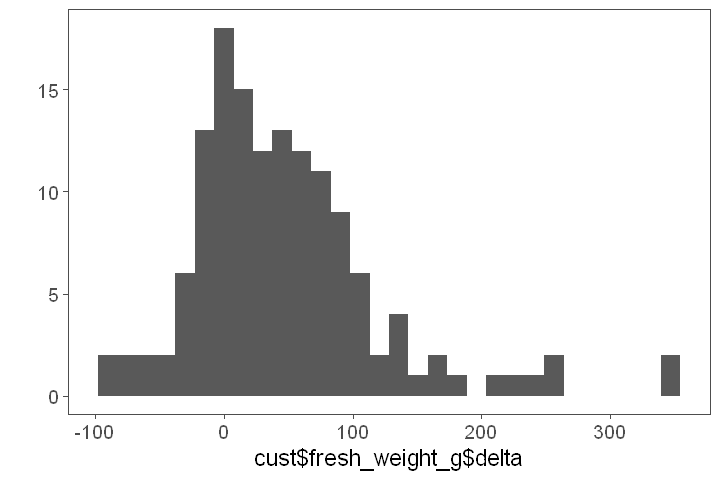

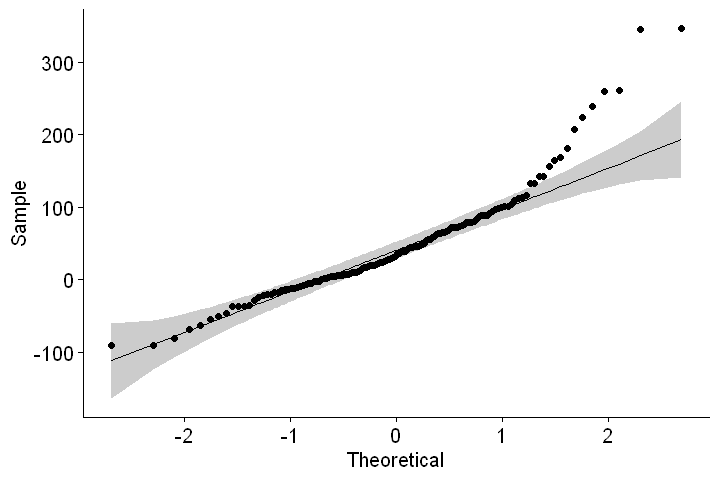

In [10]:

shapiro.test(cust$fresh_weight_g$delta)
#skewness(cust$plant_biomass$delta)
qplot(geom = "histogram",cust$fresh_weight_g$delta)
ggqqplot(cust$fresh_weight_g$delta)


In [11]:
ttest_fresh_weight_g <- wilcox.test(cust$fresh_weight_g$PROVEN40,cust$fresh_weight_g$BAU, paired = TRUE,conf.int = TRUE)
ttest_fresh_weight_g


	Wilcoxon signed rank test with continuity correction

data:  cust$fresh_weight_g$PROVEN40 and cust$fresh_weight_g$BAU
V = 8283, p-value = 3.329e-12
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 29.00000 49.45004
sample estimates:
(pseudo)median 
      39.00001 


## Final plot

In [12]:
df_for_plot <- bind_rows(cust) %>% 
mutate(variable2 = factor(variable, levels = c("fresh_weight_g","chlorophyll"), labels = c("'Change in aboveground fresh weight (g'~plant^-1*')'", "'Change in leaf chlorophyll conc. (µmol'~m^-2*')'")))

In [13]:

# Create nice axis labels
ttest_labs <- 
bind_rows(tidy(ttest_fresh_weight_g),tidy(ttest_chlorophyll)) %>% 
mutate(
    variable =  c("fresh_weight_g","chlorophyll"),
    n = c(length(unique(cust$fresh_weight_g$field_id_hash)),length(unique(cust$chlorophyll$field_id_hash))),
    type_of_estimate = c("Pseudo median","Pseudo median")) %>% 
mutate_if(is.numeric,signif, digits = 3) %>% 
mutate(ttest_label = paste0(
    #toupper(gsub("\\.","-",alternative))," ",toupper(method),
    type_of_estimate," = ",estimate,
    "\n95% CI: ",conf.low,", ",conf.high,
    "\n",ifelse(p.value < 0.0001,"p < 0.0001",paste0("p = ",p.value))
    #"\nn = ",n
    ),
    ttest_label =  gsub("e-0|e-","x10^-",gsub("RANK","RANK\\\n",ttest_label)) ) %>% 
left_join(
df_for_plot %>% 
group_by(variable,variable2) %>% 
summarise(ypos = max(delta)*1.1)
)

ttest_labs


`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.
Joining with `by = join_by(variable)`


estimate,statistic,p.value,conf.low,conf.high,method,alternative,variable,n,type_of_estimate,ttest_label,variable2,ypos
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<dbl>
39.0,8280,3.33e-12,29.00,49.5,Wilcoxon signed rank test with continuity correction,two.sided,fresh_weight_g,135,Pseudo median,"Pseudo median = 39 95% CI: 29, 49.5 p < 0.0001",'Change in aboveground fresh weight (g'~plant^-1*')',381.26000
12.6,6970,9.75e-06,7.21,17.7,Wilcoxon signed rank test with continuity correction,two.sided,chlorophyll,135,Pseudo median,"Pseudo median = 12.6 95% CI: 7.21, 17.7 p < 0.0001",'Change in leaf chlorophyll conc. (µmol'~m^-2*')',89.15792


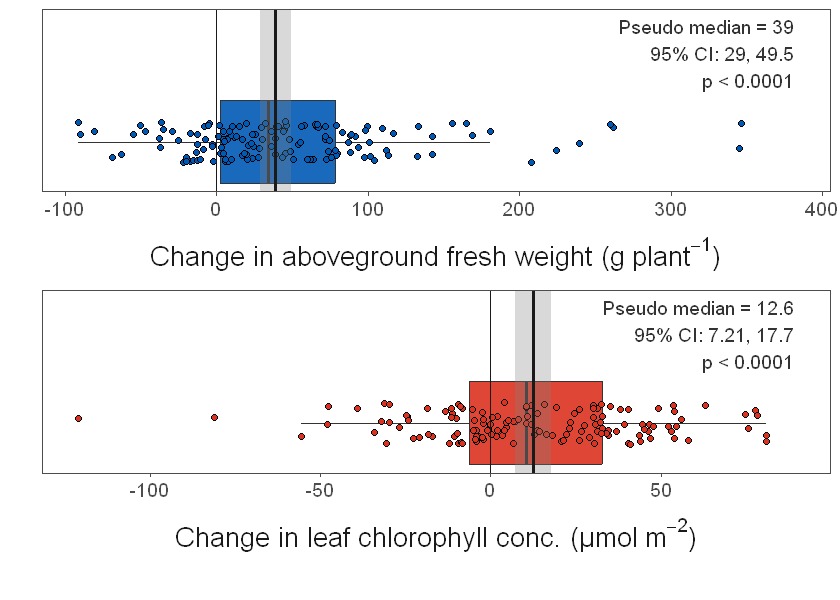

In [14]:
options(repr.plot.width=7, repr.plot.height=5)

ttest_plot <-  df_for_plot %>% 
ggplot() + 
geom_boxplot(aes(y = PROVEN40	- BAU, fill = variable2),  width = 0.2, outlier.colour = "white", alpha = 0.9) +
#geom_density(aes(PROVEN40	- NTC), bins = 30, fill = pbColor_discrete_1[2]) +
geom_jitter(aes(y= PROVEN40	- BAU, x = 0, fill = variable2), shape = 21, width = 0.05) + 
geom_rect(data = ttest_labs, aes(ymin = conf.low, ymax = conf.high, xmin = -Inf, xmax = Inf), fill = "gray50", alpha = 0.3) + 
geom_hline(data = ttest_labs, aes(yintercept = estimate), colour = "gray10", lwd = 1) + 
geom_hline(yintercept = 0, colour = "gray10") + 
geom_text(data = ttest_labs, aes(x = 0.3, y = ypos, label  = ttest_label), hjust = 1, vjust = 1, size = 4, colour = "gray20") + 
facet_wrap(~variable2, nrow = 2, scales = "free", strip.position = "bottom", labeller = label_parsed) + 
labs(y = "", x = "") + 
scale_fill_manual(values = myColorPalette) +
coord_flip() + 
theme(strip.placement = "outside", legend.position = "none", strip.text = element_text(size = 16), axis.text.y = element_blank(), axis.ticks.y = element_blank())

ttest_plot


In [15]:
gt <- read_csv("./datasets/on_farm_veg_plant_traits_ground_truth_anonymized.csv")
gt$Field_Name <- factor(paste0("Field 0",as.numeric(factor(gt$field_id_hash))," (",gt$growth_stage,")"))
names(gt)

Rows: 324 Columns: 11
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (3): field_id_hash, sample_id, growth_stage
dbl (8): treatment, rep, pair, fresh_weight_field, cci_average_field, dry_we...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "field_id_hash"           "sample_id"              
 [3] "treatment"               "growth_stage"           
 [5] "rep"                     "pair"                   
 [7] "fresh_weight_field"      "cci_average_field"      
 [9] "dry_weight_lab"          "nitrogen_percentage_lab"
[11] "g_n_plant_lab"           "Field_Name"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


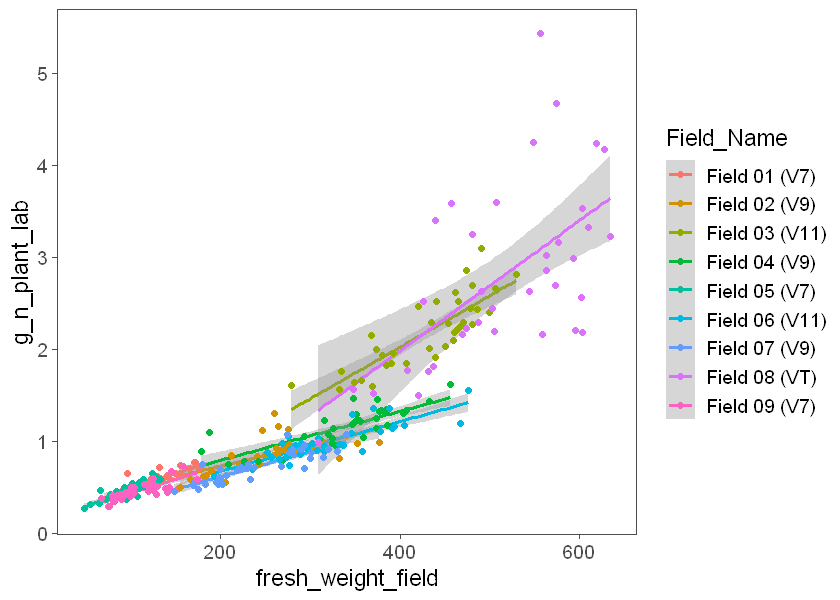

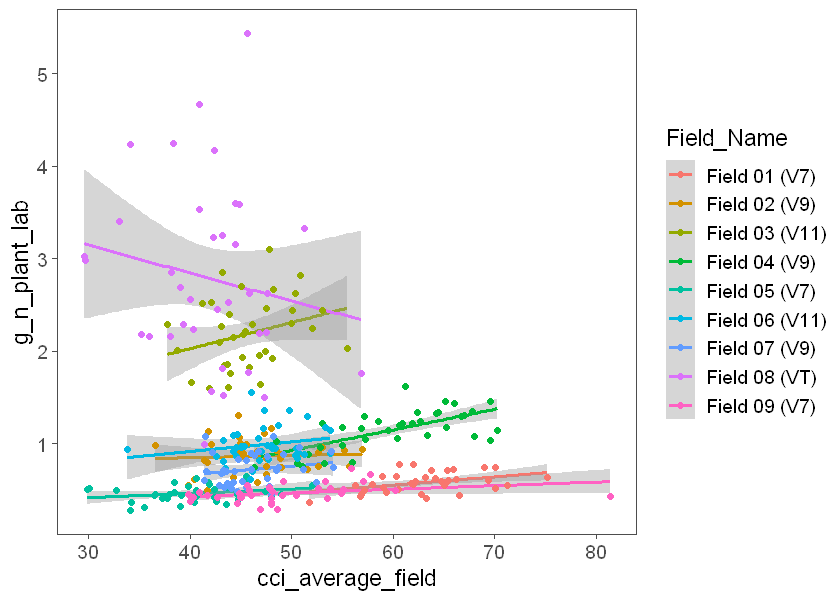

In [16]:
gt %>% 
ggplot(aes(fresh_weight_field, g_n_plant_lab, colour = Field_Name)) + 
geom_smooth(method = "lm")  + 
geom_point()

gt %>% 
ggplot(aes(cci_average_field, g_n_plant_lab, colour = Field_Name)) + 
geom_smooth(method = "lm")  + 
geom_point()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


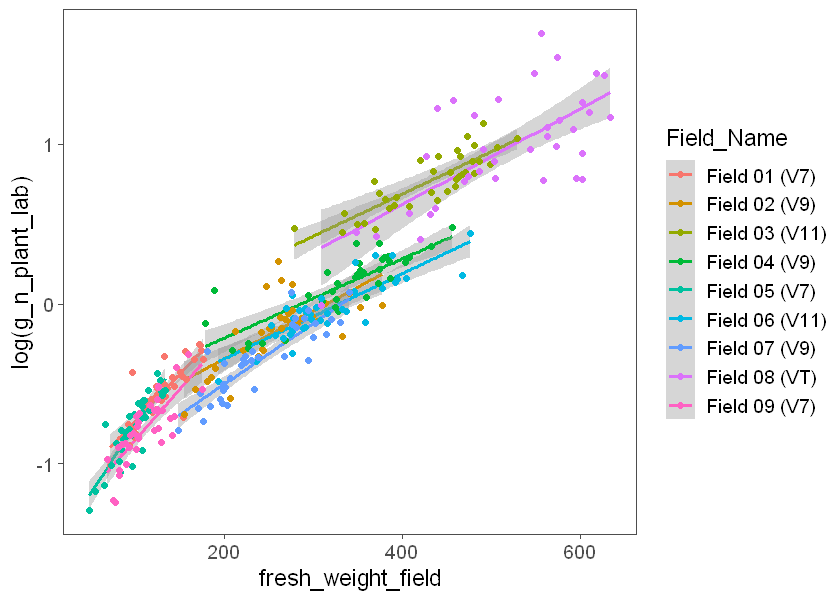

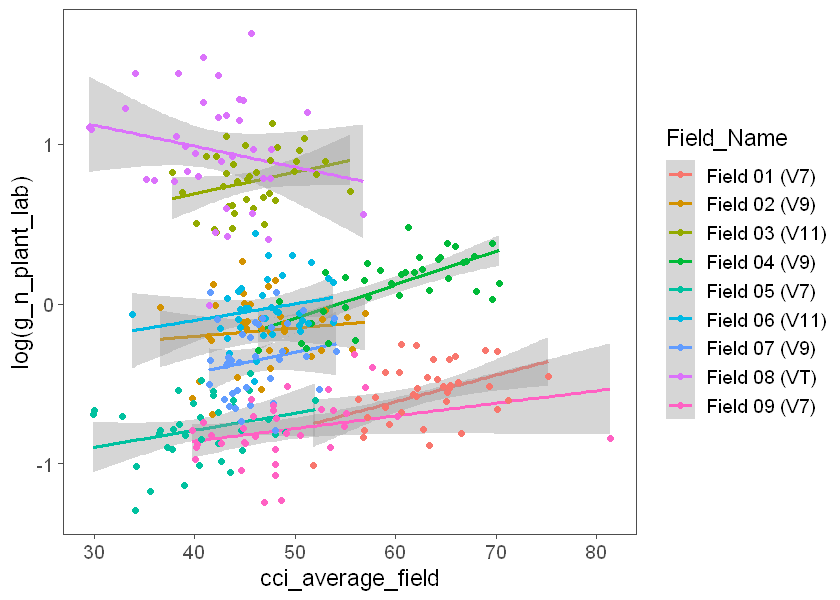

In [17]:
gt %>% 
ggplot(aes(fresh_weight_field, log(g_n_plant_lab), colour = Field_Name)) + 
geom_smooth(method = "lm")  + 
geom_point()

gt %>% 
ggplot(aes(cci_average_field, log(g_n_plant_lab), colour = Field_Name)) + 
geom_smooth(method = "lm")  + 
geom_point()

In [18]:
mod <- lm(log(g_n_plant_lab) ~ fresh_weight_field * cci_average_field, data = gt)
summary(mod)


Call:
lm(formula = log(g_n_plant_lab) ~ fresh_weight_field * cci_average_field, 
    data = gt)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59553 -0.11100 -0.01241  0.09734  0.60442 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          -1.621e+00  1.069e-01 -15.158  < 2e-16 ***
fresh_weight_field                    5.516e-03  3.640e-04  15.151  < 2e-16 ***
cci_average_field                     8.731e-03  2.190e-03   3.987 8.31e-05 ***
fresh_weight_field:cci_average_field -2.982e-05  7.766e-06  -3.840 0.000148 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1827 on 320 degrees of freedom
Multiple R-squared:  0.9175,	Adjusted R-squared:  0.9168 
F-statistic:  1187 on 3 and 320 DF,  p-value: < 2.2e-16


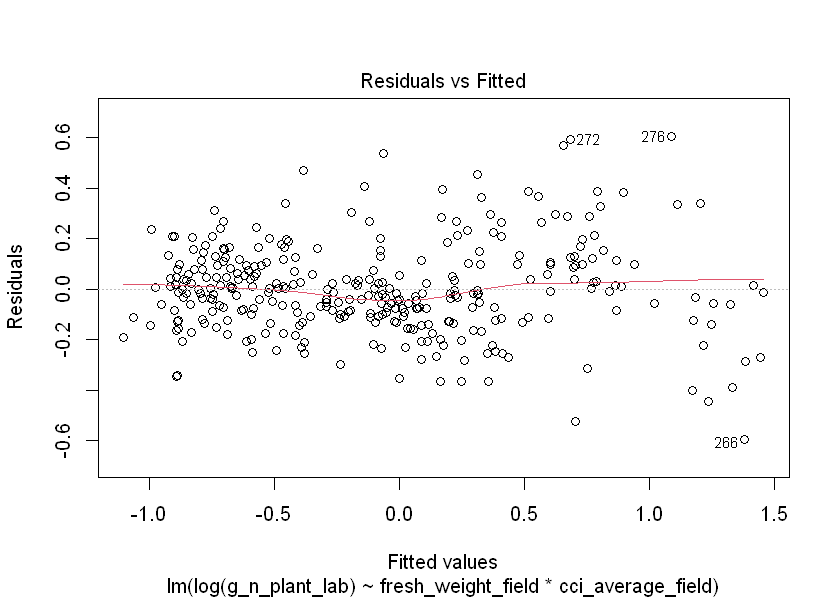

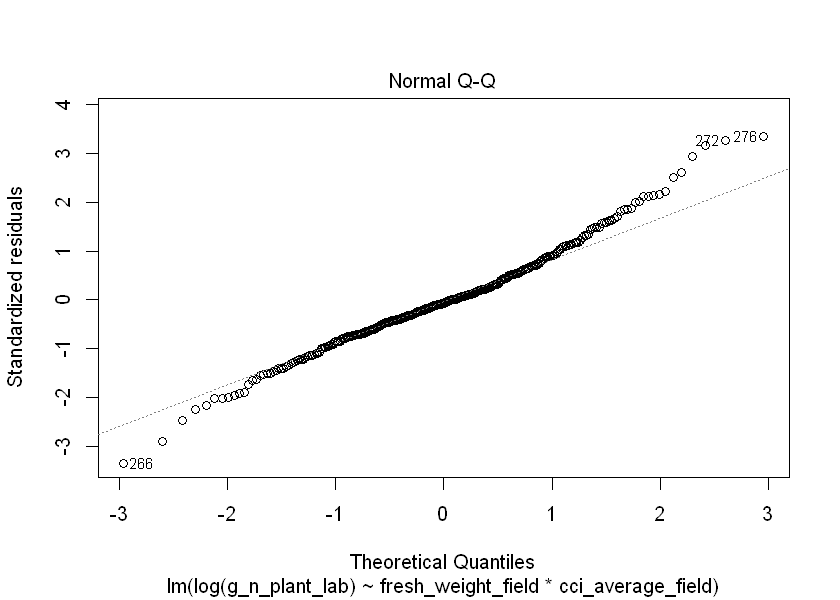

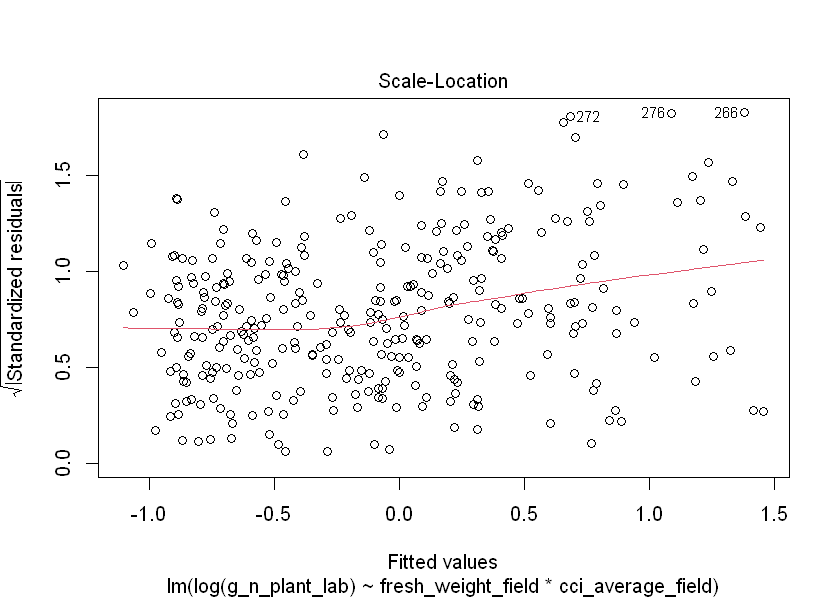

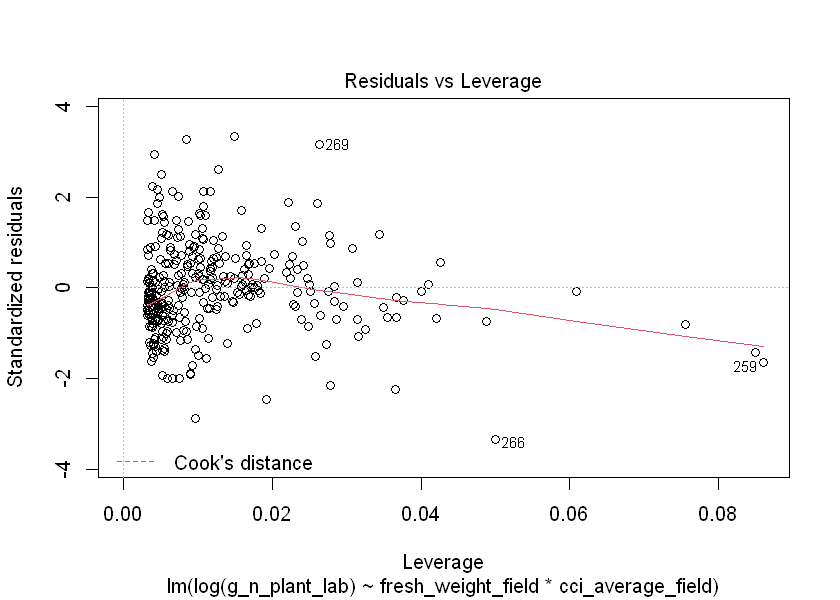

In [19]:
plot(mod)

In [20]:
# Cross validation, leave one site out
gt_coef <- foreach(i = unique(gt$Field_Name), .combine = rbind) %do%{

train <- gt %>% filter(Field_Name != i)
test <- gt %>% filter(Field_Name == i)

this.mod <- lm(log(g_n_plant_lab) ~ fresh_weight_field *  cci_average_field, data = train)

return(summary(this.mod)$coefficients %>% data.frame() %>% bind_cols(as.data.frame(confint(this.mod))) %>% mutate(term = row.names(.), model_name = paste("drop",i)))

}


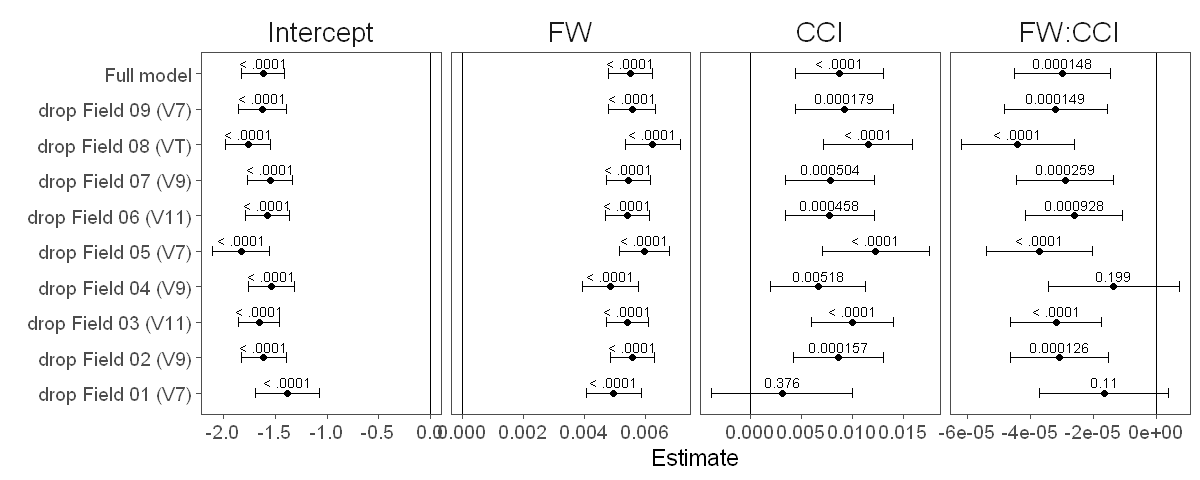

In [21]:
options(repr.plot.width=10, repr.plot.height=4)

gt_coef_plot <- gt_coef %>% 
bind_rows(summary(mod)$coefficients %>% data.frame() %>% bind_cols(as.data.frame(confint(mod))) %>% mutate(term = row.names(.), model_name = "Full model")) %>% 
mutate(term = factor(gsub("fresh_weight_field","FW",gsub("cci_average_field","CCI",gsub('\\(|\\)',"",term))),levels = c("Intercept","FW","CCI","FW:CCI"))) %>% 
ggplot(aes(Estimate,model_name)) + 
geom_point() + 
geom_text(aes(label = ifelse(Pr...t.. < 0.0001,"< .0001",signif(Pr...t..,3))), vjust = -0.5, size = 3) + 
geom_errorbarh(aes(xmin = `2.5 %`, xmax = `97.5 %`), height = 0.3) + 
facet_grid(~term, scales = "free") + 
ylab("") + 
geom_vline(xintercept = 0) 

gt_coef_plot

In [22]:
gt$pred <- predict(mod)

# Cross validation, leave one site out
gt <- foreach(i = unique(gt$Field_Name), .combine = rbind) %do%{

train <- gt %>% filter(Field_Name != i)
test <- gt %>% filter(Field_Name == i)

mod <- lm(log(g_n_plant_lab) ~ fresh_weight_field *  cci_average_field, data = train)

test$cv_pred <- predict(mod,newdata = test)

return(test)

}


In [23]:
#Compare out-of-bag vs full model performance
 
gt_cv <- gt %>%
group_by() %>%
summarise(
    r2  = R2(obs = log(g_n_plant_lab), pred = pred),
    oob_r2  = R2(obs = log(g_n_plant_lab), pred = cv_pred),
    rmse  = RMSE(obs = log(g_n_plant_lab), pred = pred),
    oob_rmse  = RMSE(obs = log(g_n_plant_lab), pred = cv_pred))
    
gt_cv

r2,oob_r2,rmse,oob_rmse
<dbl>,<dbl>,<dbl>,<dbl>
0.9175265,0.8964155,0.1815277,0.2053101


In [24]:
gt %>%
group_by(Field_Name, growth_stage) %>%
summarise(
    r2  = R2(obs = log(g_n_plant_lab), pred = pred),
    oob_r2  = R2(obs = log(g_n_plant_lab), pred = cv_pred),
    rmse  = RMSE(obs = log(g_n_plant_lab), pred = pred),
    oob_rmse  = RMSE(obs = log(g_n_plant_lab), pred = cv_pred))

`summarise()` has grouped output by 'Field_Name'. You can override using the
`.groups` argument.


Field_Name,growth_stage,r2,oob_r2,rmse,oob_rmse
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Field 01 (V7),V7,0.7152973,0.7231659,0.1142568,0.1611589
Field 02 (V9),V9,0.5221067,0.5195044,0.1595182,0.1609666
Field 03 (V11),V11,0.7261370,0.7266553,0.2411024,0.2951312
Field 04 (V9),V9,0.6892421,0.7101726,0.1394989,0.1744700
Field 05 (V7),V7,0.7180241,0.6769115,0.1416397,0.1733694
Field 06 (V11),V11,0.7259647,0.7252807,0.1801017,0.1966104
Field 07 (V9),V9,0.7606768,0.7590013,0.1676795,0.1822873
Field 08 (VT),VT,0.4779178,0.4700011,0.2855764,0.2967366
Field 09 (V7),V7,0.6127137,0.6068024,0.1353184,0.1412509


In [25]:
coeffs <- signif(coef(mod),2)

my_text <- paste0(
    "Full Model:",
    "\nLog(y) ~ ",coeffs[1]," + ",coeffs[2],"FW + ",coeffs[3],"CCI + ",coeffs[4],"FW*CCI",
    "\n\nCross-validation:",
    "\nR-squared = ",signif(gt_cv$oob_r2,3),
    "\nRMSE = ",signif(gt_cv$oob_rmse,3)
)
my_text

[1] "Full Model:\nLog(y) ~ -1.6 + 0.0056FW + 0.0092CCI + -3.2e-05FW*CCI\n\nCross-validation:\nR-squared = 0.896\nRMSE = 0.205"

In [26]:
rn_log_model  <- mod

rn_log_predict <- function(cci,fw,lmObject = rn_log_model){

out <- data.frame((predict(lmObject, newdata = data.frame(cci_average_field = cci, fresh_weight_field = fw), se.fit = TRUE, interval = "prediction", level = 0.90)))
names(out) <- c("fit","CI05","CI95","se_fit","df","residual.scale")
out
}


rn_log_percent_change_predict <- function(cci_ctl,fw_ctl,cci_trt,fw_trt){

pred_ctl <- rn_log_predict(cci_ctl,fw_ctl)
pred_trt <- rn_log_predict(cci_trt,fw_trt)

data.frame(
    percent_change = (exp(pred_trt$fit - pred_ctl$fit) - 1)*100,
    percent_change_se = (exp(sqrt(pred_trt$se_fit^2 + pred_ctl$se_fit^2)) - 1)*100
)
}

In [27]:
pred_plant_n <- rn_log_percent_change_predict(
    cci_ctl = cc_2_cci(cust$chlorophyll$BAU),
    fw_ctl = cust$fresh_weight_g$BAU,
    cci_trt = cc_2_cci(cust$chlorophyll$PROVEN40),
    fw_trt = cust$fresh_weight_g$PROVEN40)

In [28]:
options(repr.plot.width=4, repr.plot.height=4)
p2 <- bind_cols(cust$fresh_weight_g,pred_plant_n) %>% 
ggplot(aes(delta,percent_change)) + 
geom_point() + 
geom_errorbar(aes(ymax = percent_change + percent_change_se*1.96, ymin = percent_change - percent_change_se*1.96)) + 
labs(x = expression(Delta~"aboveground fresh weight (g"~plant^-1*")"), y = "")

In [29]:
p3 <- bind_cols(cust$chlorophyll,pred_plant_n) %>% 
ggplot(aes(cc_2_cci(PROVEN40) - cc_2_cci(BAU), percent_change)) + 
geom_point() + 
geom_errorbar(aes(ymax = percent_change + percent_change_se*1.96, ymin = percent_change - percent_change_se*1.96)) + 
labs(x = expression(Delta~" CCI (dimensionless)"), y = "")

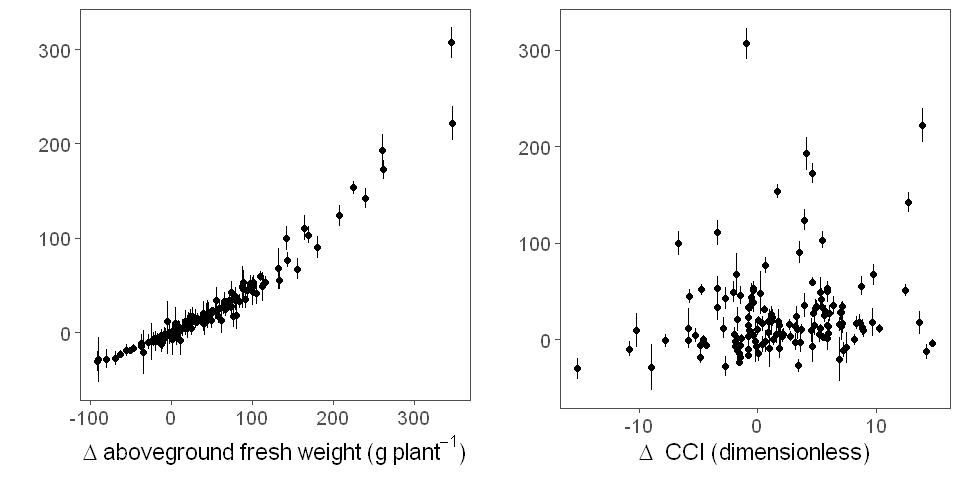

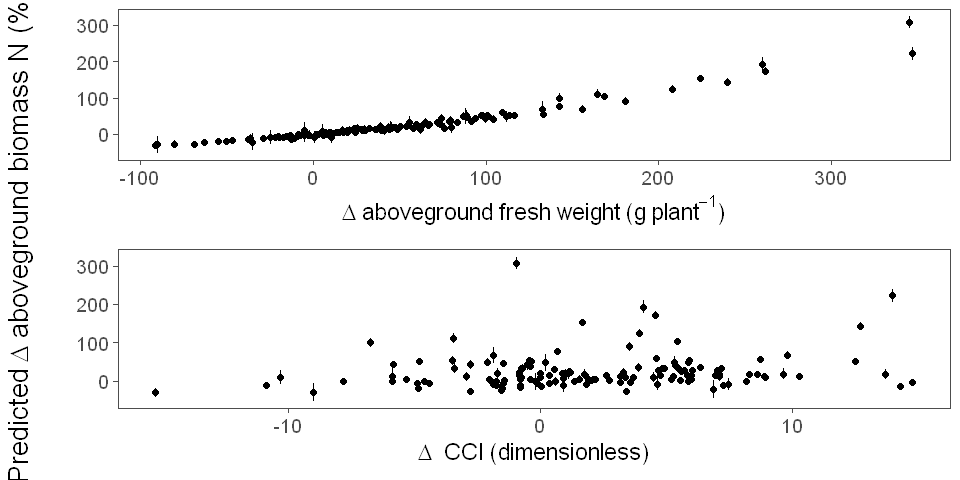

In [30]:
options(repr.plot.width=8, repr.plot.height=4)

ggarrange(p2,p3)
annotate_figure(ggarrange(p2,p3, nrow = 2),left = text_grob(expression("Predicted"~Delta~"aboveground biomass N (%)"), rot = 90, size = 16) )

In [31]:
options(repr.plot.width=6, repr.plot.height=6)

gt_cv_plot <- gt %>% 
mutate(growth_stage = factor(growth_stage, levels = c("V7","V9","V11","VT"))) %>%
ggplot(aes(cv_pred,log(g_n_plant_lab))) + 
geom_point(aes(fill = Field_Name), shape = 21, size = 4) +
geom_abline(intercept = 0, slope = 1, linetype = 2) + 
#geom_smooth(method = "lm", se = F, colour = "red") + 
labs(y = "Observed", x = "Out-of-bag CV prediction\n(Leave one site out)", 
shape = "Site:", fill = "Site:",
title = "Log(Plant N (g N/plant))") +
coord_equal(ylim = c(-1.5,2.5), xlim = c(-1.5,2.5), expand = FALSE) +  
theme(plot.title = element_text(hjust = 0.5), legend.position = c(0.85,0.3), legend.background = element_blank()) + 
annotate("text", x = -1.3, y = 2.4, label = my_text, size = 4,  hjust = 0, vjust = 1)


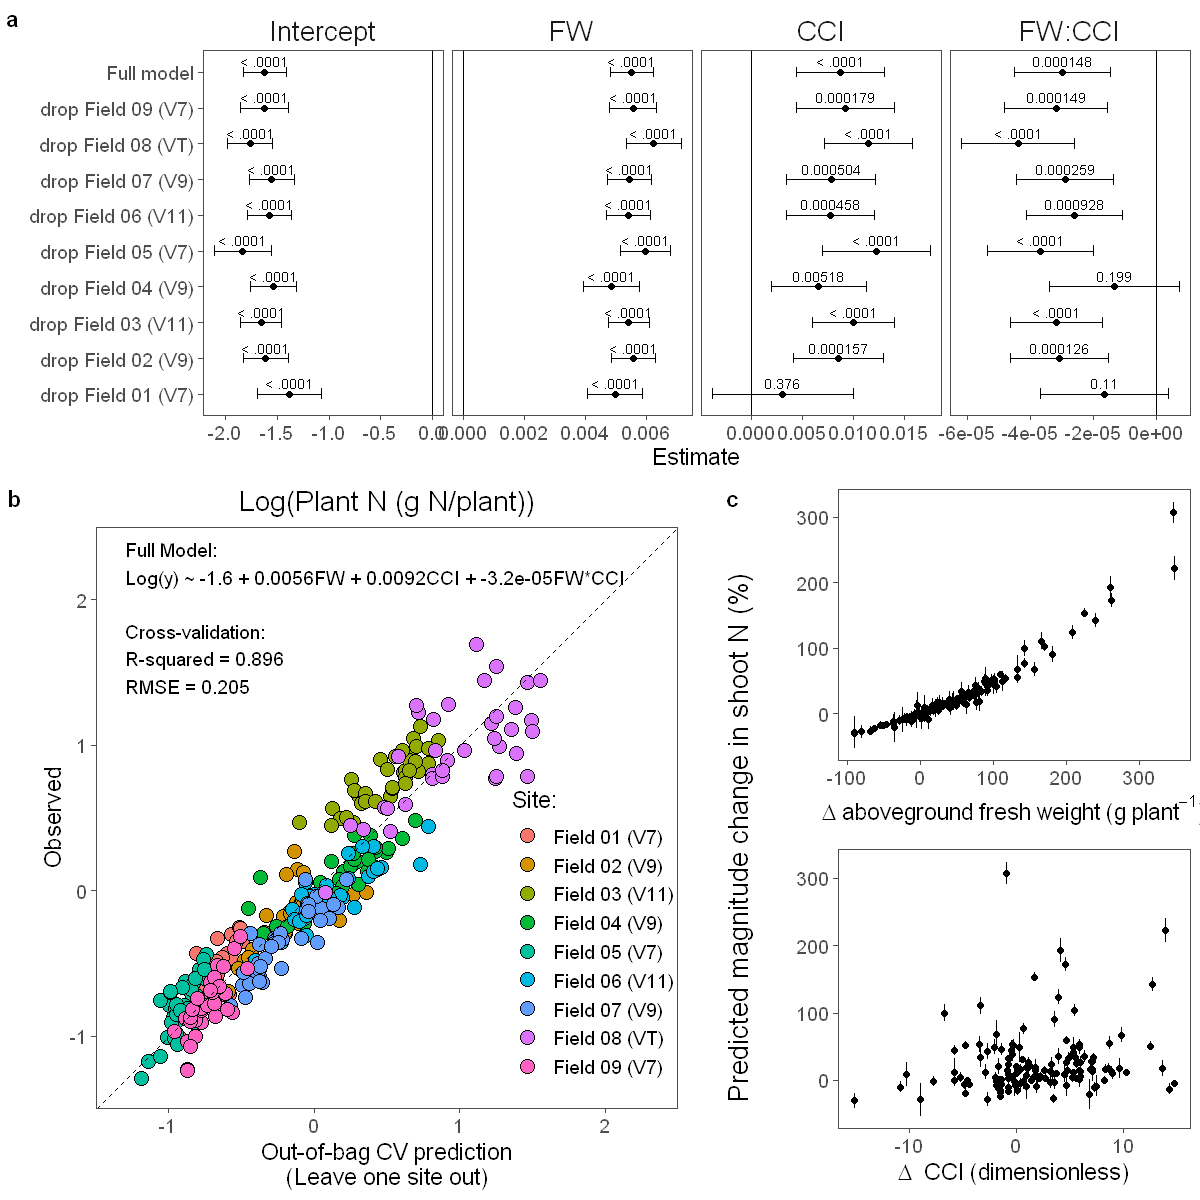

In [32]:
options(repr.plot.width=10, repr.plot.height=10)

ggarrange(
    gt_coef_plot,
    ggarrange(gt_cv_plot,
    annotate_figure(ggarrange(p2,p3, nrow = 2),left = text_grob(expression("Predicted magnitude change in shoot N (%)"), rot = 90, size = 16)),
    widths = c(3,2),labels = c("b","c")),
    nrow = 2, labels = c("a",""),
    heights = c(2,3)
)

ggsave("./figures/freshwt_cci_vs_logplantn_supplemental_figure.jpeg",width = 10, height = 10)


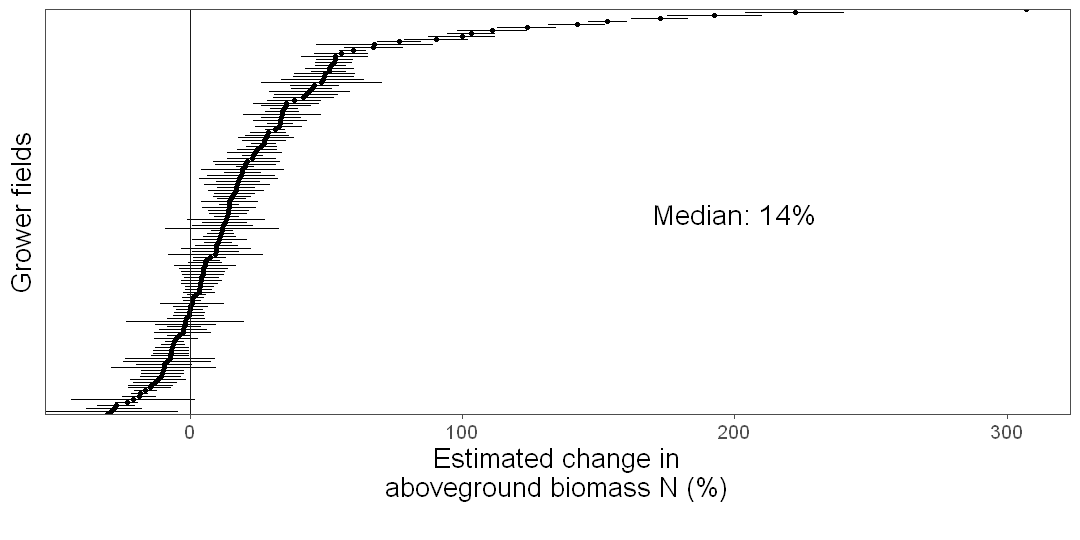

In [35]:
pred_plant_n_plot <- pred_plant_n %>% 
arrange(percent_change) %>% 
mutate(rank = 1:n()/5000) %>% 
ggplot() + 
#geom_density(aes(x = percent_change), fill = "gray90") + 
geom_point(aes(percent_change,rank), size =1) + 
geom_errorbarh(aes(y = rank, xmax = percent_change + percent_change_se*1.96, xmin = percent_change - percent_change_se*1.96), height = 0) + 
geom_vline(xintercept = 0, colour = "gray10") + 
labs(y = "Grower fields", x = "Estimated change in\naboveground biomass N (%)\n") + 
coord_cartesian(expand = FALSE) + 
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title = element_text(size = 16)) + 
annotate("text", x = 200, y = dim(pred_plant_n)[1]/2/5000, label = paste0("Median: ", round(median(pred_plant_n$percent_change),1),"%"), size = 6)

pred_plant_n_plot

#ggsave("./figures/fig4c.jpeg",width = 4, height = 5)

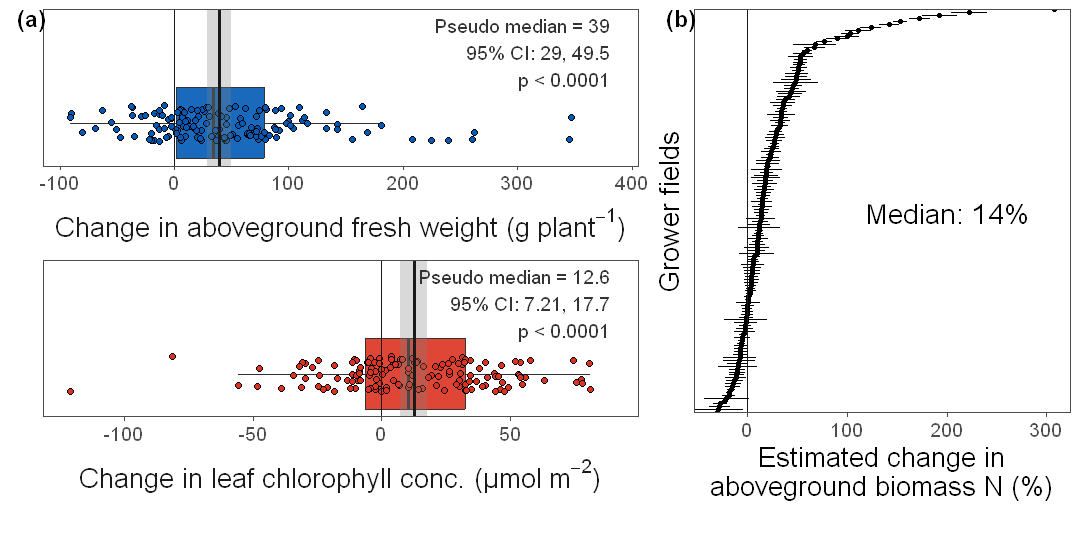

In [36]:
options(repr.plot.width=9, repr.plot.height=4.5)

ggarrange(ttest_plot,pred_plant_n_plot, labels = c("(a) ","(b) "), nrow = 1, widths = c(3,2))
ggsave("./figures/on_farm_early_season_traits.jpeg",width = 9, height = 4.5)